In [1]:
import keras
import tensorflow as tf
from keras import layers
from keras.datasets import mnist
import numpy as np
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from matplotlib.pyplot import imread
from tensorflow.keras.utils import to_categorical

2023-11-09 11:28:43.609435: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-09 11:28:43.830385: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-09 11:28:43.918999: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-09 11:28:44.659332: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

# **Utils**

In [2]:
def fp_quantize(x, w, f):
    i = w - f
    max = float(2 ** (i - 1) - 2 ** (-f))
    min = float(-2 ** (i - 1))
    n = float(2 ** f)
    xx = np.floor(x * n + 0.5) / n
    clipped = np.clip(xx, a_min=min, a_max=max)
    return clipped

In [3]:
def FPToHex(x, w = 8, f = 7):
    x_fix = x
    x_fix = x_fix * pow(2, f)
    x_fix = int(x_fix)
    if(x_fix < 0):
        binary = bin(x_fix+(1<<w))
    else:
        binary = bin(x_fix)
    return hex(int(binary, 2))[2:]

def WriteFixPToFile(file_name, data_fp, w = 8, f = 7, mode = "w"):
    with open(file_name, mode) as file:
        for i in range(data_fp.shape[0]):
            file.write(str(FPToHex(data_fp[i], w=w, f=f))+'\n')

In [4]:
def twos_complement(bin_num, w, f):
    # Perform 2's complement on the binary number
    flipped = ''
    for bit in bin_num:
        flipped += '0' if bit == '1' else '1'
    comp_num = int(flipped, 2) + 1

    return bin(comp_num)[2:].zfill(len(bin_num))

def fixed_point_to_float(bin_num, w=16, f=14):
        # Check if the number is negative
    sign_bit = int(bin_num[0])
    if sign_bit:
        bin_num = twos_complement(bin_num, w, f)

    # Split the binary number into integer and fractional parts
    if f > 0:
        if f == w:
            float_num = int(bin_num, 2) / 2**f
        else:
            int_part = int(bin_num[:-f], 2)
            frac_part = int(bin_num[-f:], 2) / 2**f
            float_num = int_part + frac_part
    else:
        int_part = int(bin_num, 2)
        float_num = int_part

    # Apply the sign to the floating point number if it was negative
    if sign_bit:
        float_num = -float_num

    return float_num

def hex_to_fixed_point_decimal(hex_value, w, f):
    binary_value = bin(int(hex_value, 16))[2:]

    # # Determine the sign bit
    binary_value = binary_value.zfill(w)

    # return decimal_value
    return fixed_point_to_float(binary_value, w, f)

# **Data Preparation**

In [5]:
LETTERS = {'A': 0, 'B': 1, 'C': 2, 0: 'A', 1: 'B', 2: 'C'}

In [6]:
IMAGE_SIZE = 28

In [7]:
images = np.load("images.npy")
labels = np.load("labels.npy")

In [8]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [9]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [10]:
def resize_images(images, new_size=(28, 28)):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, new_size)
        resized_images.append(resized_img)
    return np.array(resized_images)

In [11]:
x_train = resize_images(x_train, (IMAGE_SIZE, IMAGE_SIZE))
x_test = resize_images(x_test, (IMAGE_SIZE, IMAGE_SIZE))

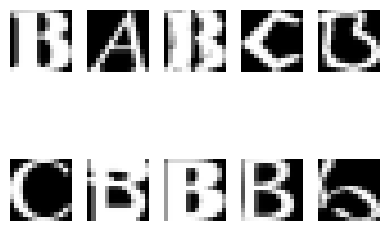

In [12]:
plt.figure(figsize=(4, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[i], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [13]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(126985, 196)
(31747, 196)


In [ ]:
model = None #create the model

# **Save Weights as Fixed Point**

In [ ]:
y1 = None #replace it with the output of the first layer (after its activation layer)

In [22]:
WriteFixPToFile("input.txt", y1[0][0], 9, 7)

In [83]:
if not os.path.exists('weights'):
    os.mkdir('weights')

In [24]:
count = 0
for layer in model.layers:
    weights = layer.get_weights()        
    if weights and len(weights) > 0:
        count += 1
        w_per_neuron = weights[0].shape[0]
        w = np.array(layer.kernel_quantizer(weights[0])).transpose().reshape(-1,)
        b = np.array(layer.kernel_quantizer(weights[1])).reshape(-1,)
        separate_weights = [np.concatenate((w[c:c+w_per_neuron], b[int(c/w_per_neuron):int(c/w_per_neuron)+1]), axis=0) for c in range(0, len(w), w_per_neuron)]
        
        #pay attention to this part 
        width, f = (17, 14) if layer.name == 'last' else (9, 7) #pay attention to this part 
        for n, s in enumerate(separate_weights):
            WriteFixPToFile(f"weights/layer_{count}_{n + 1}_w.mem", s, width, f)

##############################################################################